<a href="https://colab.research.google.com/github/Untick/IrisID_gr1/blob/Vitaly-Krasikov-folder/Vitaly%20Krasikov/iris_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Работа с массивами
import numpy as np

# Подключение модуля для загрузки данных из облака
import gdown

# Инструменты для работы с файлами
import os

# Отрисовка графиков
import matplotlib.pyplot as plt

# Сегментация картинок
import cv2

# разбор xml
import xml.etree.ElementTree as ET

# Рисование графиков в ячейках Colab
%matplotlib inline

In [15]:
# Задание гиперпараметров

DATA_PATH          = '/content/iris'       # Папка для набора данных
RESULT_PATH        = '/content/iris_flat'   # Папка для преобразованного набора данных
ANNOT_PATH         = '/content/annotations.xml' # Путь к файлу с разметкой

IMG_WIDTH           = 192                   # Ширина изображения для нейросети
IMG_HEIGHT          = 144                   # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)

## Сбор и подготовка данных

In [3]:
# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab (89 классов)
gdown.download('https://drive.google.com/uc?id=1owRM4vWprid-FKgGoRg3BEPWWF-B-evq', None, quiet=True)

'iris89.zip'

In [4]:
# Очистка данных от прошлого запуска (если есть)
!rm -rf {DATA_PATH}

# Разархивация датасета в директорию данных
!unzip -qo "iris89.zip" -d {DATA_PATH}

In [5]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(DATA_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 89, метки классов: ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089']


## Сегментация радужки

22 346 3 327
0.25709876543209875


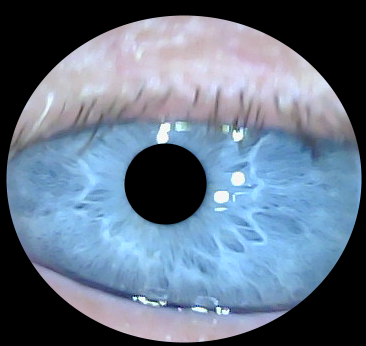

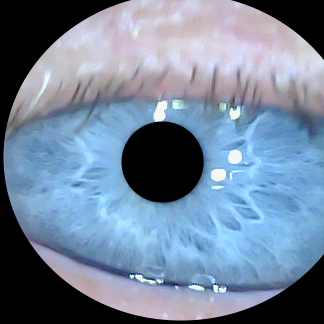

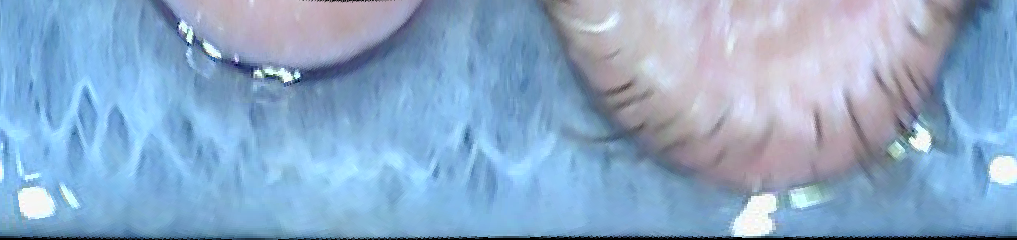

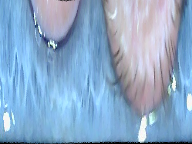

In [8]:
import cv2
import math
from google.colab.patches import cv2_imshow


# взял функции у Андрея Шалунова и немного доработал

# обрезка изображения до квадрата
def unwrap_circular_image(image, iris=None, pupil=None):

    height, width = image.shape[:2]
    if pupil is None:
      # вычисляем центр изображения
      center_x, center_y = width // 2, height // 2
    else:
      # Берем центр зрачка за центр изображения
      center_x, center_y = pupil['cx'], pupil['cy']
    # Вычисляем максимальный радиус окружности
    max_radius = min(center_x, center_y, width - center_x, height - center_y)

    return image[int(center_y - max_radius): int(center_y + max_radius), int(center_x - max_radius): int(center_x + max_radius)]

# перевод из полярной системы координат в декартову
def ring_to_rect(image, iris=None, pupil=None):

  size = image.shape[0]  # исходное изображение должно быть квадратным

  if iris is None:
    outer_radius = size // 2.5   # это радиус радужки
  else:
    # здесь не учтено, что в центре изображения находится центр зрачка, а не радужки
    outer_radius = min(iris['rx'], iris['ry'])
  if pupil is None:
    inner_radius_factor = 0.375   # это радиус зрачка
  else:
    inner_radius_factor = 2*max(pupil['rx'], pupil['ry']) / size

  # Разворачиваем кольцо
  warped = cv2.warpPolar(image, (size, int(size * math.pi)), (size // 2, size // 2), outer_radius, 0)
  # Поворачиваем на 90 градусов
  straightened = cv2.rotate(warped, cv2.ROTATE_90_COUNTERCLOCKWISE)
  # Обрезаем
  cropped = straightened[: int(straightened.shape[0] * (1 - inner_radius_factor)), :]

  return cropped

# хочу использовать ImageDataGenerator и туда передавать свою функцию предобработки,
# но там есть странное требование, что входное и выходное изображение должны быть
# одного размера, короче, это костыль, потом надо будет переделать
# хотя, с другой стороны, что такое маленький resize по сравнению с тем, 
# что с изображением нейронка потом делает
# функция изменения размера изображения
def resize(image):
  return cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT)).astype('float64')

img = cv2.imread('./iris/068/068L_6.png')
iris = {'cx': 183.91, 'cy': 186.55, 'rx': 176.61, 'ry': 153.90}
pupil = {'cx': 165.50, 'cy': 184.09, 'rx': 41.65, 'ry': 41.16}

unwrapped_image = unwrap_circular_image(img, pupil=pupil)
rect_image = ring_to_rect(unwrapped_image, iris, pupil)
resized_image = resize(rect_image)

cv2_imshow(img)
cv2_imshow(unwrapped_image)
cv2_imshow(rect_image)
cv2_imshow(resized_image)

## Загрузка разметки

In [12]:
# Загрузка аннотаций с гугл диска
gdown.download('https://drive.google.com/uc?id=1KSN0QzXlOLpfdTn8nYvJOLe1i1LLJ_d2', None, quiet=True)

'annotations.xml'

In [29]:
def load_annotations(path=ANNOT_PATH):
  result = {}
  tree = ET.parse(path)
  root = tree.getroot()
  for image in root.findall('image'):
    elem = {}
    for label in image:
        elem[label.attrib['label']] = {'cx': float(label.attrib['cx']), 'cy': float(label.attrib['cy']), 
                                       'rx': float(label.attrib['rx']), 'ry': float(label.attrib['ry'])}
    result[image.attrib['name']] = elem
  return result

In [31]:
annot = load_annotations()

In [32]:
annot

{'001/001L_1.png': {'iris': {'cx': 368.91,
   'cy': 295.17,
   'rx': 262.77,
   'ry': 244.66},
  'pupil': {'cx': 352.45, 'cy': 288.04, 'rx': 63.09, 'ry': 59.79}},
 '001/001L_2.png': {'pupil': {'cx': 367.56,
   'cy': 263.78,
   'rx': 74.06,
   'ry': 70.86},
  'iris': {'cx': 387.67, 'cy': 274.75, 'rx': 271.54, 'ry': 261.94}},
 '001/001L_3.png': {'pupil': {'cx': 380.36,
   'cy': 253.26,
   'rx': 69.49,
   'ry': 65.83},
  'iris': {'cx': 399.56, 'cy': 260.12, 'rx': 274.29, 'ry': 257.37}},
 '001/001R_1.png': {'iris': {'cx': 364.36,
   'cy': 299.44,
   'rx': 271.09,
   'ry': 260.11},
  'pupil': {'cx': 374.41, 'cy': 284.35, 'rx': 66.29, 'ry': 62.17}},
 '001/001R_2.png': {'iris': {'cx': 355.22,
   'cy': 266.98,
   'rx': 281.14,
   'ry': 263.31},
  'pupil': {'cx': 362.98, 'cy': 250.98, 'rx': 66.74, 'ry': 60.8}},
 '001/001R_3.png': {'iris': {'cx': 373.96,
   'cy': 284.35,
   'rx': 279.77,
   'ry': 265.14},
  'pupil': {'cx': 386.3, 'cy': 276.12, 'rx': 64.46, 'ry': 61.26}},
 '002/002L_1.png': {'pup

## Обработка всех картинок и пересохранение в новый каталог

In [33]:
os.mkdir(f'{RESULT_PATH}')
for class_name in CLASS_LIST:
    class_files = os.listdir(f'{DATA_PATH}/{class_name}')
    os.mkdir(f'{RESULT_PATH}/{class_name}')
    for f in class_files:
      f_path = f'{class_name}/{f}'
      img = cv2.imread(f'{DATA_PATH}/{f_path}')
      img_modified = resize(ring_to_rect(unwrap_circular_image(img, pupil=annot[f_path]['pupil']),annot[f_path]['iris'],annot[f_path]['pupil']))
      cv2.imwrite(f'{RESULT_PATH}/{f_path}', img_modified)

0 501 112 613
0.26642714570858284
0 527 103 631
0.28106261859582543
0 552 110 662
0.23355072463768115
0 568 90 658
0.2334154929577465
0 506 127 633
0.27466403162055336
0 576 64 640
0.21906250000000002
0 541 91 632
0.29404805914972276
0 553 92 645
0.3124773960216998
0 545 101 646
0.26840366972477064
0 555 86 642
0.27509909909909913
0 520 130 650
0.28834615384615386
0 558 91 650
0.30641577060931896
0 516 123 640
0.2923643410852713
0 515 127 642
0.3124660194174757
0 475 126 602
0.32143157894736846
0 523 154 678
0.2919311663479924
0 496 132 628
0.30600806451612905
0 489 154 643
0.31038854805725974
0 557 105 663
0.2806822262118492
0 567 119 687
0.2531569664902998
0 549 82 632
0.25315118397085606
0 574 92 666
0.2373170731707317
0 544 128 672
0.275625
0 557 61 618
0.24951526032315977
0 513 132 645
0.27267056530214423
0 542 116 658
0.25132841328413286
0 523 116 640
0.25521988527724665
0 506 103 610
0.3234387351778656
0 526 114 640
0.2503041825095057
0 537 102 640
0.2707262569832402
9 576 116 6